# DATA CLEANING

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Step 1: Preprocess Dataset
def preprocess_dataset(file_path, output_path):
    # Load the dataset
    print("Loading dataset...")
    data = pd.read_csv(file_path)

    # Check initial column types
    print("Initial column types:")
    print(data.dtypes)

    # Convert `vehicle_id` to numeric
    print("Converting vehicle_id to numeric...")
    label_encoder = LabelEncoder()
    data['vehicles_id'] = label_encoder.fit_transform(data['vehicle_id'])
    data.drop(columns=['vehicle_id'], inplace=True)  # Drop the original `vehicle_id` column

    # Ensure all columns have the correct data types
    print("Ensuring relevant data types...")
    data = data.astype({
        'time': 'float32',
        'speed': 'float32',
        'angle': 'float32',
        'longitude': 'float32',
        'latitude': 'float32',
        'acceleration': 'float32',
        'angular_velocity': 'float32',
        'distance': 'float32',
        'anomaly_scores': 'int32',
        'anomaly': 'int32',
        'vehicles_id': 'int32',
    })

    # Save the processed dataset
    print("Saving preprocessed dataset...")
    data.to_csv(output_path, index=False)
    print(f"Preprocessed dataset saved to {output_path}")

    return data, label_encoder

# Step 2: Main Function
def main():
    input_file = "inliers_with_features.csv"  # Path to your dataset
    output_file = "preprocessed_inliers.csv"  # Path to save the preprocessed dataset

    # Preprocess the dataset
    data, label_encoder = preprocess_dataset(input_file, output_file)

    # Display the first few rows
    print("Preprocessed Dataset Preview:")
    print(data.head(10))

if __name__ == "__main__":
    main()


Loading dataset...
Initial column types:
time                float64
vehicle_id           object
speed               float64
angle               float64
longitude           float64
latitude            float64
acceleration        float64
angular_velocity    float64
distance            float64
anomaly_scores        int64
anomaly               int64
dtype: object
Converting vehicle_id to numeric...
Ensuring relevant data types...
Saving preprocessed dataset...
Preprocessed dataset saved to preprocessed_inliers.csv
Preprocessed Dataset Preview:
   time  speed       angle  longitude  latitude  acceleration  \
0   0.0  13.89  231.550003   0.089241  4.613104          0.00   
1   0.0   0.00  130.869995   0.054450  4.570659          0.00   
2   1.0  16.40  231.550003   0.089148  4.612988          2.51   
3   1.0   2.59  130.869995   0.054435  4.570677          2.59   
4   2.0  18.51  231.550003   0.089044  4.612858          2.11   
5   2.0   0.00  176.619995   0.083407  4.603940          0.00  

# Normalize Dataset with MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load Dataset
data = pd.read_csv("preprocessed_inliers.csv")

# Columns to Normalize
columns_to_scale = ['longitude', 'latitude', 'speed', 'angle', 'acceleration', 'angular_velocity', 'distance']

# Apply MinMaxScaler
scaler = MinMaxScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Save the normalized dataset
data.to_csv("normalized_inliers.csv", index=False)
print("Normalized dataset saved as 'normalized_inliers.csv'.")


Normalized dataset saved as 'normalized_inliers.csv'.


In [ ]:
print(data.head(10))

   time     speed     angle  longitude  latitude  acceleration  \
0   0.0  0.277967  0.643194   0.863400  0.834559      0.316456   
1   0.0  0.000000  0.363528   0.526865  0.486734      0.316456   
2   1.0  0.328197  0.643194   0.862507  0.833613      0.404712   
3   1.0  0.051831  0.363528   0.526717  0.486881      0.407525   
4   2.0  0.370422  0.643194   0.861500  0.832546      0.390647   
5   2.0  0.000000  0.490611   0.806971  0.759459      0.316456   
6   2.0  0.000000  0.803250   0.568409  0.546771      0.316456   
7   2.0  0.109065  0.363528   0.526406  0.487185      0.417018   
8   3.0  0.397238  0.637389   0.860400  0.831412      0.363572   
9   3.0  0.049430  0.543722   0.806819  0.759332      0.403305   

   angular_velocity  distance  anomaly_scores  anomaly  vehicles_id  
0          0.500007  0.000000               1        0          142  
1          0.500007  0.000000               1        0       281845  
2          0.500007  0.329200               1        0         

# data batch process

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]  # Input sequence
        label = data[i+seq_length, :4]  # Predicting longitude, latitude, velocity, direction
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def process_data_in_batches(file_path, seq_length=10, batch_size=100, output_dir="batch_data"):
    # Load the preprocessed dataset
    print("Loading preprocessed dataset...")
    data = pd.read_csv(file_path)

    # Ensure output directory exists
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Select relevant columns for processing
    features = ['longitude', 'latitude', 'speed', 'angle', 'distance', 'vehicles_id']
    grouped = data.groupby('vehicles_id')

    # Initialize variables
    batch_id = 0
    sequences, labels = [], []

    print("Processing data in batches...")
    for i, (vehicle_id, group) in enumerate(grouped):
        group_sequences, group_labels = create_sequences(group[features].values, seq_length)

        # Accumulate sequences and labels
        sequences.extend(group_sequences)
        labels.extend(group_labels)

        # Save batch after processing `batch_size` vehicles
        if (i + 1) % batch_size == 0:
            np.savez(f"{output_dir}/trajectory_batch_{batch_id}.npz", sequences=np.array(sequences), labels=np.array(labels))
            print(f"Batch {batch_id} saved with {len(sequences)} sequences.")
            batch_id += 1
            sequences, labels = [], []  # Reset for the next batch

    # Save the last batch if it contains data
    if sequences:
        np.savez(f"{output_dir}/trajectory_batch_{batch_id}.npz", sequences=np.array(sequences), labels=np.array(labels))
        print(f"Final batch {batch_id} saved with {len(sequences)} sequences.")

    print(f"Processed data into {batch_id + 1} batches.")

# Main Function
def main():
    input_file = "preprocessed_inliers.csv"  # Preprocessed dataset
    seq_length = 10  # Length of each sequence
    batch_size = 100  # Number of vehicles per batch
    output_dir = "batch_data"  # Directory to save the batches

    # Process data into batches
    process_data_in_batches(input_file, seq_length, batch_size, output_dir)

if __name__ == "__main__":
    main()


Loading preprocessed dataset...
Processing data in batches...
Batch 0 saved with 38744 sequences.
Batch 1 saved with 47618 sequences.
Batch 2 saved with 35354 sequences.
Batch 3 saved with 29217 sequences.
Batch 4 saved with 37592 sequences.
Batch 5 saved with 40008 sequences.
Batch 6 saved with 33175 sequences.
Batch 7 saved with 49761 sequences.
Batch 8 saved with 44233 sequences.
Batch 9 saved with 33046 sequences.
Batch 10 saved with 35399 sequences.
Batch 11 saved with 29083 sequences.
Batch 12 saved with 38398 sequences.
Batch 13 saved with 32541 sequences.
Batch 14 saved with 47850 sequences.
Batch 15 saved with 55831 sequences.
Batch 16 saved with 40522 sequences.
Batch 17 saved with 28443 sequences.
Batch 18 saved with 33282 sequences.
Batch 19 saved with 36207 sequences.
Batch 20 saved with 50959 sequences.
Batch 21 saved with 55214 sequences.
Batch 22 saved with 49721 sequences.
Batch 23 saved with 48680 sequences.
Batch 24 saved with 41902 sequences.
Batch 25 saved with 368

# Load Batches and Split into Train and Test


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

batch_size = 100  # Number of vehicles per batch
batch_id = 0

# Define batch files
batch_files = [f"batch_data/trajectory_batch_{i}.npz" for i in range(batch_id + 1)]  # Update batch_id to match the number of batches

# Load all batches
sequences, labels = [], []
for batch_file in batch_files:
    data = np.load(batch_file, allow_pickle=True)
    sequences.append(data['sequences'])
    labels.append(data['labels'])

# Concatenate all batches
sequences = np.concatenate(sequences, axis=0)
labels = np.concatenate(labels, axis=0)

print(f"Loaded {len(sequences)} sequences and {len(labels)} labels.")

# Split into train and test sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Save train and test datasets
np.savez("batch_data/train_test_data_batched.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

print(f"Train shapes: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test shapes: X_test={X_test.shape}, y_test={y_test.shape}")


Loaded 38744 sequences and 38744 labels.
Train shapes: X_train=(30995, 10, 6), y_train=(30995, 4)
Test shapes: X_test=(7749, 10, 6), y_test=(7749, 4)


# Train the LSTM Model

Loading train/test data...
X_train shape: (30995, 10, 6), y_train shape: (30995, 4)
X_test shape: (7749, 10, 6), y_test shape: (7749, 4)
Defining LSTM model...
Model compiled successfully.
Training the model...


/home/sumo/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 4598.5464 - val_loss: 3335.9631
Epoch 2/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 3110.8196 - val_loss: 2394.7288
Epoch 3/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2253.2629 - val_loss: 1754.1785
Epoch 4/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 1563.9968 - val_loss: 1150.2467
Epoch 5/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1098.3353 - val_loss: 788.3071
Epoch 6/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 744.8123 - val_loss: 537.6484
Epoch 7/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 523.7118 - val_loss: 374.1102
Epoch 8/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 352.2344 - val_loss: 270.5826
Epoch 9/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 278.6060 - val_loss: 211.5766
Epoch 10/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 228.2184 - val_loss: 175.3821
Epoch 11/20
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 181.749

Model training complete and saved successfully!
Evaluating the model...
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test RMSE: 5.243518640456288
Test predictions saved successfully!


/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


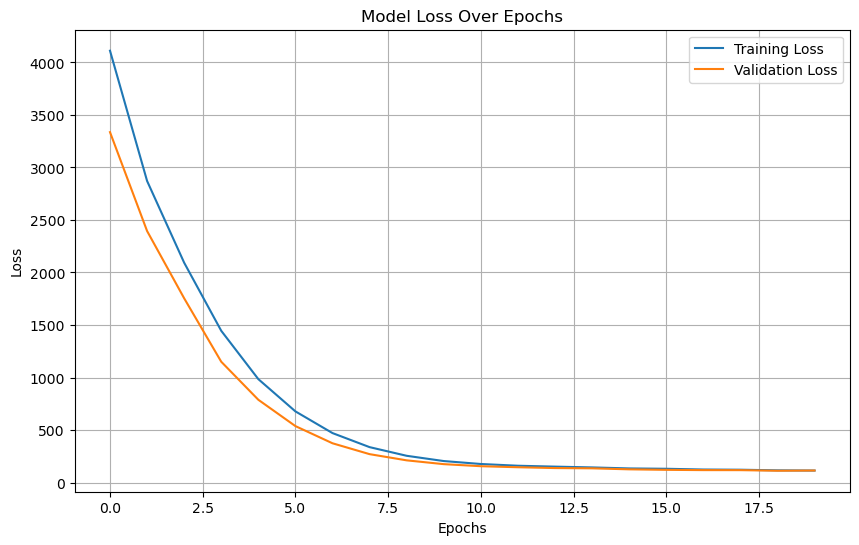

In [ ]:
# import numpy as np
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error

# def train_lstm_model():
#     # Load train/test data
#     print("Loading train/test data...")
#     data = np.load("batch_data/train_test_data_batched.npz")
#     X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

#     # Verify shapes
#     print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
#     print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

#     # Define the LSTM model
#     print("Defining LSTM model...")
#     model = Sequential([
#         LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
#         LSTM(32, return_sequences=False),
#         Dense(4)  # Predicting longitude, latitude, velocity, direction
#     ])

#     # Compile the model
#     model.compile(optimizer='adam', loss='mse')
#     print("Model compiled successfully.")

#     # Train the model
#     print("Training the model...")
#     history = model.fit(
#         X_train, y_train,
#         epochs=20,
#         batch_size=32,
#         validation_split=0.2,
#         verbose=1
#     )

#     # Save the trained model
#     model.save("batch_data/trajectory_lstm_model.h5")
#     print("Model training complete and saved successfully!")

#     # Evaluate the model
#     print("Evaluating the model...")
#     y_pred = model.predict(X_test)
#     rmse = mean_squared_error(y_test, y_pred, squared=False)
#     print(f"Test RMSE: {rmse}")

#     # Save predictions
#     np.savez("batch_data/test_predictions.npz", true=y_test, predicted=y_pred)
#     print("Test predictions saved successfully!")

#     # Plot training and validation loss
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss Over Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()
#     plt.show()

# if __name__ == "__main__":
#     train_lstm_model()
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def train_lstm_model():
    # Load train/test data
    print("Loading train/test data...")
    data = np.load("batch_data/train_test_data_batched.npz")
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # Verify shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Define the Bidirectional LSTM model
    print("Defining Bidirectional LSTM model...")
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dense(4)  # Predicting longitude, latitude, velocity, direction
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    print("Model compiled successfully.")

    # Train the model
    print("Training the model...")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Save the trained model
    model.save("batch_data/trajectory_bilstm_model.h5")
    print("Model training complete and saved successfully!")

    # Evaluate the model
    print("Evaluating the model...")
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Test RMSE: {rmse}")

    # Save predictions
    np.savez("batch_data/test_predictions.npz", true=y_test, predicted=y_pred)
    print("Test predictions saved successfully!")

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Bidirectional LSTM Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    train_lstm_model()


#  Evaluate the Model

243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test RMSE: 45.067110659276615


/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


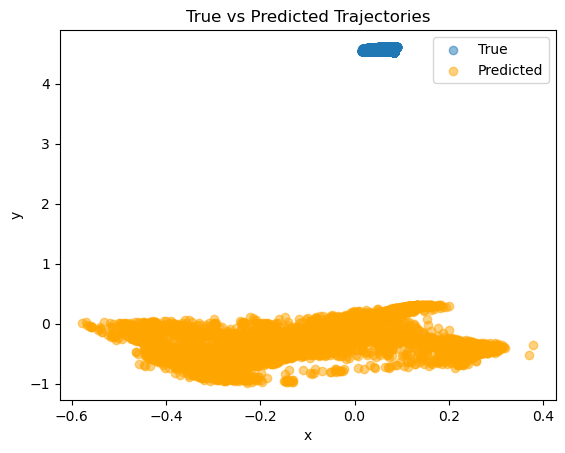

In [ ]:
from sklearn.metrics import mean_squared_error

# Predict on test data
predictions = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Test RMSE: {rmse}")

# Visualize true vs predicted trajectories
import matplotlib.pyplot as plt

plt.scatter(y_test[:, 0], y_test[:, 1], label='True', alpha=0.5)
plt.scatter(predictions[:, 0], predictions[:, 1], label='Predicted', alpha=0.5, color='orange')
plt.legend()
plt.title('True vs Predicted Trajectories')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [ ]:
# Save predictions
np.savez("test_predictions_batched.npz", true=y_test, predicted=predictions)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the test dataset
predictions = model.predict(X_test)

# Calculate metrics for X and Y coordinates separately
mse_x = mean_squared_error(y_test[:, 0], predictions[:, 0])
mse_y = mean_squared_error(y_test[:, 1], predictions[:, 1])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
mae_x = mean_absolute_error(y_test[:, 0], predictions[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], predictions[:, 1])
r2_x = r2_score(y_test[:, 0], predictions[:, 0])
r2_y = r2_score(y_test[:, 1], predictions[:, 1])

# Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_true, y_pred):
    return np.mean(200 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

smape_x = smape(y_test[:, 0], predictions[:, 0])
smape_y = smape(y_test[:, 1], predictions[:, 1])

# Save metrics to a file
with open("lstm_evaluation_metrics.txt", "w") as f:
    f.write("LSTM Model Evaluation Metrics:\n")
    f.write(f"MSE X: {mse_x:.4f}, MSE Y: {mse_y:.4f}\n")
    f.write(f"RMSE X: {rmse_x:.4f}, RMSE Y: {rmse_y:.4f}\n")
    f.write(f"R² X: {r2_x:.4f}, R² Y: {r2_y:.4f}\n")
    f.write(f"MAE X: {mae_x:.4f}, MAE Y: {mae_y:.4f}\n")
    f.write(f"SMAPE X: {smape_x:.4f}, SMAPE Y: {smape_y:.4f}\n")

print("Metrics saved to 'lstm_evaluation_metrics.txt'")


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Metrics saved to 'lstm_evaluation_metrics.txt'


Loading test data and predictions...
y_test shape: (7749, 4), y_pred shape: (7749, 4)
RMSE for longitude: 0.0187
RMSE for latitude: 0.0296
RMSE for velocity: 1.5562
RMSE for direction: 19.3696
Visualizing predictions vs. true values...


/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

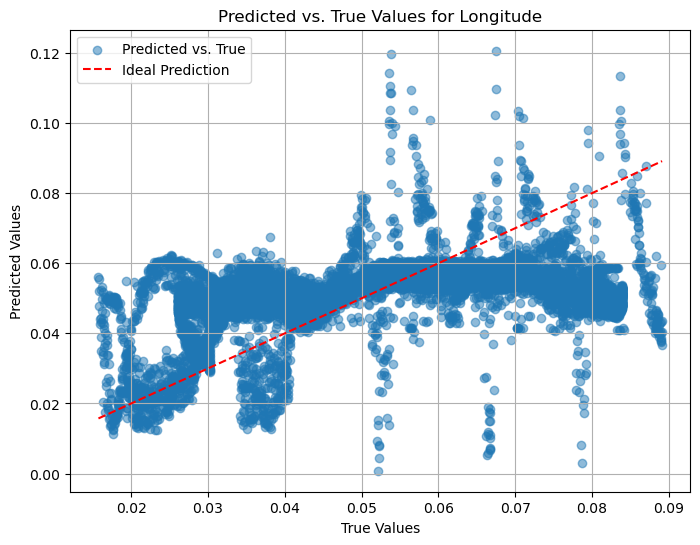

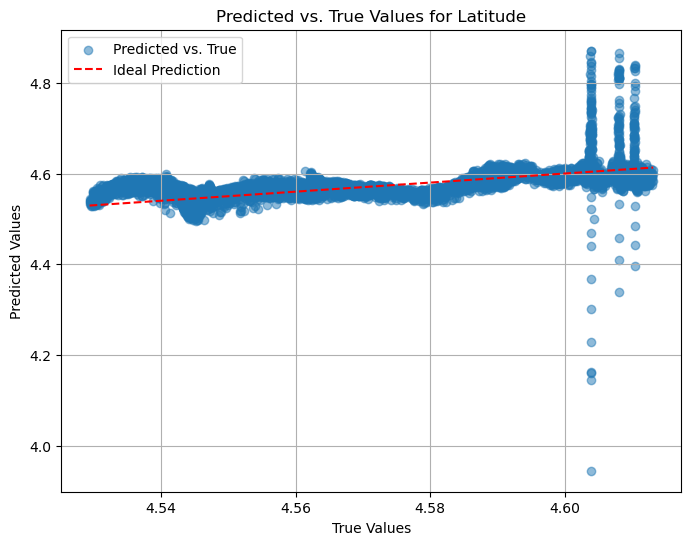

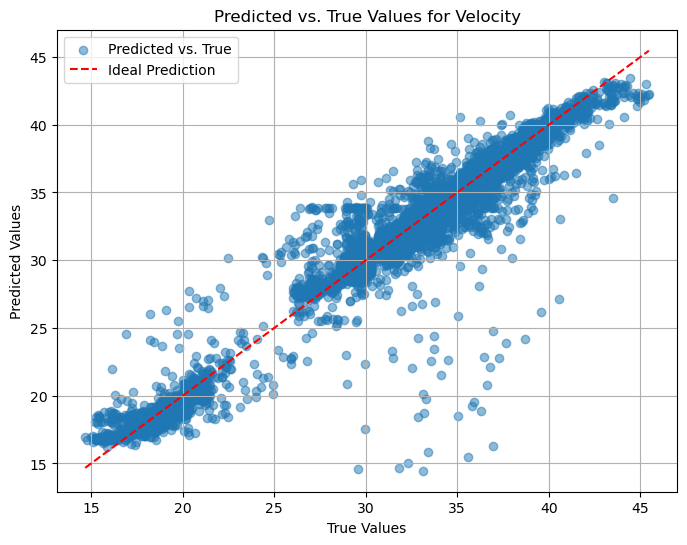

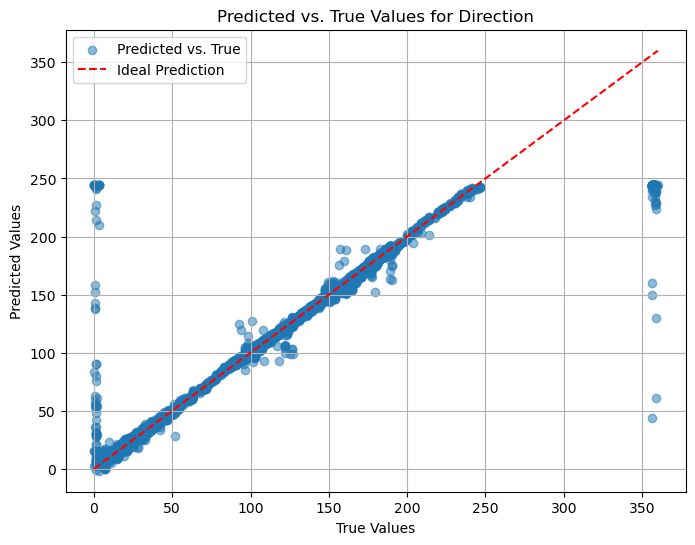

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluate_predictions():
    # Load test data and predictions
    print("Loading test data and predictions...")
    data = np.load("batch_data/test_predictions.npz")
    y_test = data['true']
    y_pred = data['predicted']

    # Ensure shapes match
    print(f"y_test shape: {y_test.shape}, y_pred shape: {y_pred.shape}")

    # Calculate RMSE for each feature
    features = ['longitude', 'latitude', 'velocity', 'direction']
    rmse_values = []
    for i, feature in enumerate(features):
        rmse = mean_squared_error(y_test[:, i], y_pred[:, i], squared=False)
        rmse_values.append(rmse)
        print(f"RMSE for {feature}: {rmse:.4f}")

    # Visualize predictions vs. true values for each feature
    print("Visualizing predictions vs. true values...")
    for i, feature in enumerate(features):
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5, label='Predicted vs. True')
        plt.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()],
                 color='red', linestyle='--', label='Ideal Prediction')
        plt.title(f'Predicted vs. True Values for {feature.capitalize()}')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == "__main__":
    evaluate_predictions()


# Tranning for 100 epocs

Loading train and test data...
X_train shape: (30995, 10, 6), y_train shape: (30995, 4)
X_test shape: (7749, 10, 6), y_test shape: (7749, 4)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,724 (120.02 KB)

 Trainable params: 30,724 (120.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
771/775 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4597.0278
Epoch 1: saving model to checkpoints/epoch_01.keras
775/775 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 4593.9331 - val_loss: 3329.8503
Epoch 2/100
774/775 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3108.3262
Epoch 2: saving model to checkpoints/epoch_02.keras
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 3107.6763 - val_loss: 2372.3147
Epoch 3/100
773/775 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2209.2969
Epoch 3: saving model to checkpoints/epoch_03.keras
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2208.7437 - val_loss: 1739.9944
Epoch 4/100
773/775 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1643.1854
Epoch 4: saving model to checkpoints/epoch_04.keras
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 1642.5994 - val_loss: 1152.6949
Epoch 5/100
773/775 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1099.8468
Epoch 5: saving model to checkpoints/epoch_05.keras
775/775 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step -

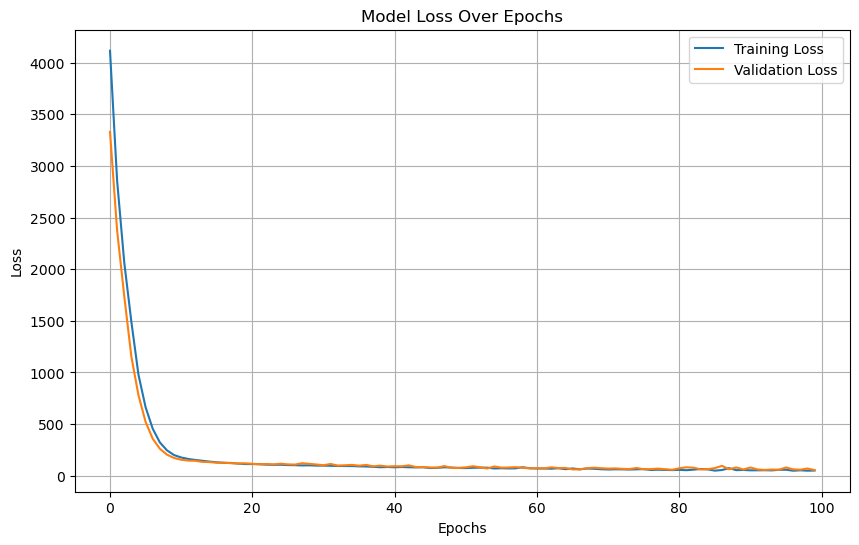

243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test predictions saved successfully!
Evaluating model...
RMSE for longitude: 0.0180
RMSE for latitude: 0.0130
RMSE for velocity: 1.7446
RMSE for direction: 15.0680


/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load train/test data
def load_data():
    print("Loading train and test data...")
    data = np.load("batch_data/train_test_data_batched.npz", allow_pickle=True)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train.astype('float32'), X_test.astype('float32'), y_train.astype('float32'), y_test.astype('float32')

# Define the LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=(input_shape[1], input_shape[2]), return_sequences=True),
        LSTM(32, return_sequences=False),
        Dense(4)  # Predicting longitude, latitude, velocity, direction
    ])
    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    return model

# Train the LSTM model
def train_model(model, X_train, y_train):
    # Define checkpoint to save model at each epoch
    checkpoint_callback = ModelCheckpoint(
        filepath="checkpoints/epoch_{epoch:02d}.keras",  # Use .keras format
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[checkpoint_callback]
    )
    return history

# Save predictions
def save_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    np.savez("batch_data/test_predictions_100.npz", true=y_test, predicted=predictions)
    print("Test predictions saved successfully!")

# Visualize training loss
def visualize_training_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate the model
def evaluate_model(y_test, predictions):
    print("Evaluating model...")
    features = ['longitude', 'latitude', 'velocity', 'direction']
    for i, feature in enumerate(features):
        rmse = mean_squared_error(y_test[:, i], predictions[:, i], squared=False)
        print(f"RMSE for {feature}: {rmse:.4f}")

# Main workflow
def main():
    X_train, X_test, y_train, y_test = load_data()
    model = build_model(X_train.shape)
    history = train_model(model, X_train, y_train)
    visualize_training_loss(history)
    save_predictions(model, X_test, y_test)

    # Evaluate predictions
    data = np.load("batch_data/test_predictions_100.npz")
    evaluate_model(data['true'], data['predicted'])

if __name__ == "__main__":
    main()


Loading test data and predictions...
y_test shape: (7749, 4), y_pred shape: (7749, 4)
Evaluating model...
RMSE for Longitude: 0.0180
RMSE for Latitude: 0.0130
RMSE for Velocity: 1.7446
RMSE for Direction: 15.0680


/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/sumo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

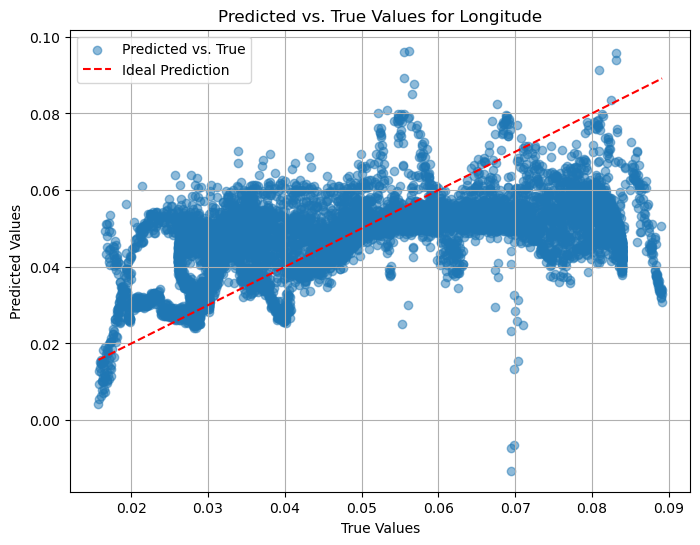

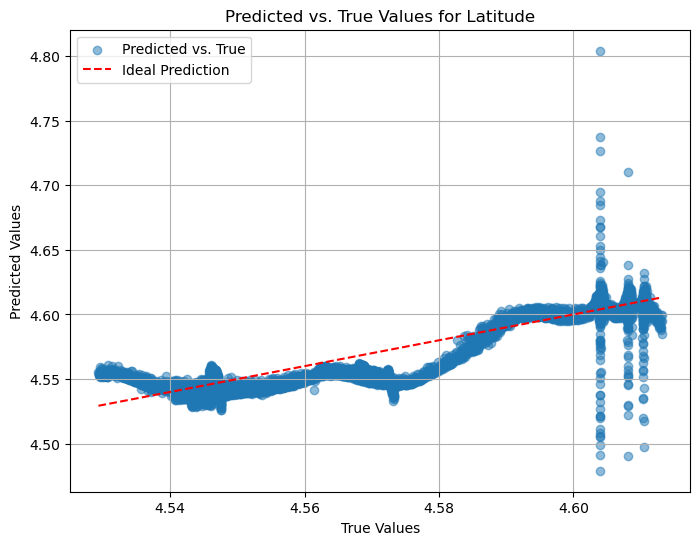

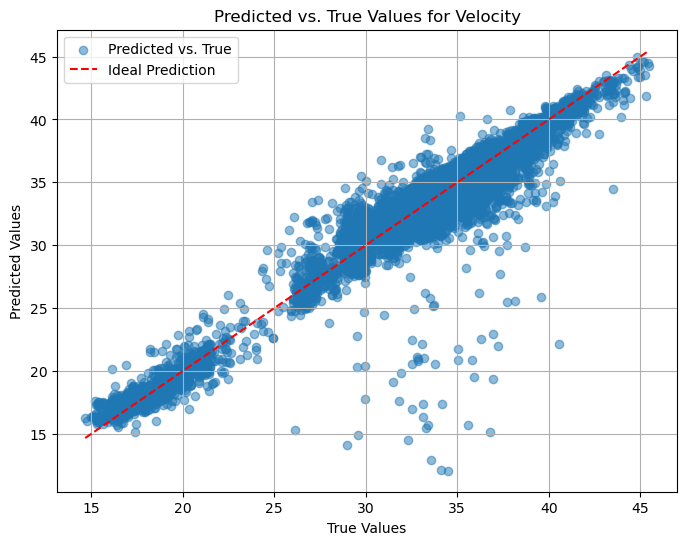

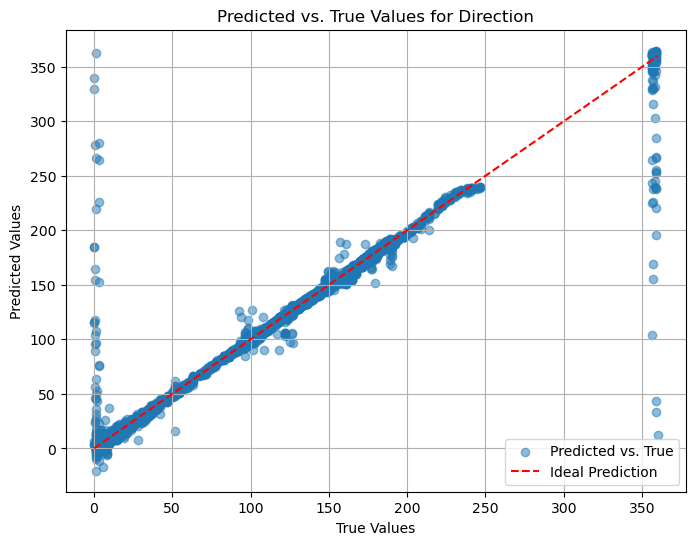

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load predictions and test data
def load_predictions():
    print("Loading test data and predictions...")
    data = np.load("batch_data/test_predictions_100.npz", allow_pickle=True)
    y_test = data['true']
    y_pred = data['predicted']
    print(f"y_test shape: {y_test.shape}, y_pred shape: {y_pred.shape}")
    return y_test, y_pred

# Visualize true vs. predicted values
def plot_predictions(y_test, y_pred, feature_names):
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5, label="Predicted vs. True")
        plt.plot(
            [y_test[:, i].min(), y_test[:, i].max()],
            [y_test[:, i].min(), y_test[:, i].max()],
            'r--',
            label="Ideal Prediction"
        )
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Predicted vs. True Values for {feature.capitalize()}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Evaluate the model using RMSE
def evaluate_model(y_test, y_pred, feature_names):
    print("Evaluating model...")
    for i, feature in enumerate(feature_names):
        rmse = mean_squared_error(y_test[:, i], y_pred[:, i], squared=False)
        print(f"RMSE for {feature.capitalize()}: {rmse:.4f}")

# Main visualization function
def visualize_results():
    y_test, y_pred = load_predictions()
    feature_names = ['longitude', 'latitude', 'velocity', 'direction']

    # Evaluate model
    evaluate_model(y_test, y_pred, feature_names)

    # Plot predictions
    plot_predictions(y_test, y_pred, feature_names)

if __name__ == "__main__":
    visualize_results()


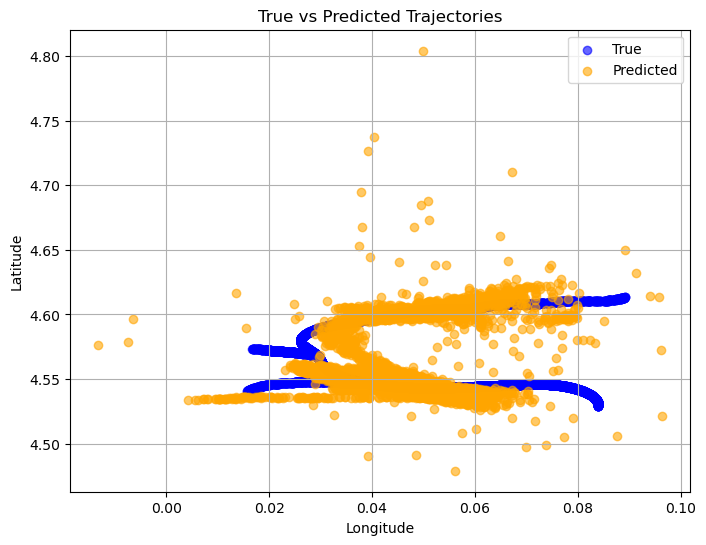

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_true_vs_predicted_trajectories(y_test, y_pred):
    """
    Plot true vs predicted trajectories (latitude vs longitude).
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, 0], y_test[:, 1], label='True', alpha=0.6, color='blue')
    plt.scatter(y_pred[:, 0], y_pred[:, 1], label='Predicted', alpha=0.6, color='orange')
    plt.title('True vs Predicted Trajectories')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Load predictions and true test values
predictions = np.load("batch_data/test_predictions_100.npz")
y_test = predictions['true']
y_pred = predictions['predicted']

# Plot the true vs predicted trajectories
plot_true_vs_predicted_trajectories(y_test, y_pred)
